# Siamese Network Architecture using MNIST Dataset

In [159]:
# -*- encoding: utf-8 -*-
import argparse
import torch
import torchvision.datasets as dsets
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms
import pickle
import torch
import torch.nn as nn

In [160]:
# Preprocess data
class Dataset(object):

    def __init__(self, x0, x1, label):
        self.size = label.shape[0]
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1] / 255.)
            x1_data.append(data[z2] / 255.)
            label.append(1)
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1] / 255.)
            x1_data.append(data[z2] / 255.)
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32)
    x0_data = x0_data.reshape([-1, 1, 28, 28])
    x1_data = np.array(x1_data, dtype=np.float32)
    x1_data = x1_data.reshape([-1, 1, 28, 28])
    label = np.array(label, dtype=np.int32)
    return x0_data, x1_data, label


def create_iterator(data, label, batchsize, shuffle=False):
    digit_indices = [np.where(label == i)[0] for i in range(10)]
    x0, x1, label = create_pairs(data, digit_indices)
    ret = Dataset(x0, x1, label)
    return ret


# Loss Function: Contrastive Loss Function 

In [161]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidian distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)

    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

# Defining Siamese Network Architecture

In [162]:
class SiameseNetwork(nn.Module):
    def __init__(self,flag_kaf=False):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 4 * 4, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [163]:
def plot_mnist(numpy_all, numpy_labels,name="../Results/embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999']

        for i in range(10):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        plt.savefig(name)

In [164]:
batchsize=8
train = dsets.MNIST(root='../data/',train=True,download=True)
test = dsets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))
indices= np.random.choice(len(train.train_labels.numpy()), 500, replace=False)
indices_test= np.random.choice(len(test.test_labels.numpy()), 50, replace=False)
print (indices_test)

[6777 2728 2450 3831 7634 2781 9646 7808 5046 4164 4562 3852 9155 4061
  892 8571 7961 5447 6580 2515 9190 3000 4702 3074 7142 1333 2360 7539
 5780 5950 5288 2067 8508 9892 4355 3902 5688 3811 6022 2502 2938 1183
 6950 8907 3684 8932 9286 6204 9559 3134]


In [165]:
train_iter = create_iterator(train.train_data.numpy()[indices],train.train_labels.numpy()[indices],batchsize)
test_iter = create_iterator(test.test_data.numpy()[indices_test],test.test_labels.numpy()[indices_test],batchsize)
# model
model = SiameseNetwork()
learning_rate = 0.01
momentum = 0.9
# Loss and Optimizer
criterion = contrastive_loss_function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)
#kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {}
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_iter,batch_size=batchsize, shuffle=True, **kwargs)


In [166]:
train_loss = []
running_loss=0.0
epochs =100
for epoch in range(epochs):
    print('Train Epoch:'+str(epoch)+"------------------")
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model(x0, x1)
        loss = criterion(output1, output2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % batchsize == 0:
            print('Batch id: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, batch_idx * len(labels), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    torch.save(model.state_dict(), './model-epoch-%s.pth' % epoch)


Train Epoch:0------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.182743
Batch id: 8 [64/820 (8%)]	Loss: 0.294567
Batch id: 16 [128/820 (16%)]	Loss: 0.264909
Batch id: 24 [192/820 (23%)]	Loss: 0.191437
Batch id: 32 [256/820 (31%)]	Loss: 0.085343
Batch id: 40 [320/820 (39%)]	Loss: 0.081894
Batch id: 48 [384/820 (47%)]	Loss: 0.142088
Batch id: 56 [448/820 (54%)]	Loss: 0.056993
Batch id: 64 [512/820 (62%)]	Loss: 0.059235
Batch id: 72 [576/820 (70%)]	Loss: 0.111203
Batch id: 80 [640/820 (78%)]	Loss: 0.101546
Batch id: 88 [704/820 (85%)]	Loss: 0.101908
Batch id: 96 [768/820 (93%)]	Loss: 0.047335
Train Epoch:1------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.136001
Batch id: 8 [64/820 (8%)]	Loss: 0.086304
Batch id: 16 [128/820 (16%)]	Loss: 0.077194
Batch id: 24 [192/820 (23%)]	Loss: 0.077295
Batch id: 32 [256/820 (31%)]	Loss: 0.066750
Batch id: 40 [320/820 (39%)]	Loss: 0.169665
Batch id: 48 [384/820 (47%)]	Loss: 0.091509
Batch id: 56 [448/820 (54%)]	Loss: 0.023729
Batch id: 64 [512/820 (62%

Batch id: 80 [640/820 (78%)]	Loss: 0.002170
Batch id: 88 [704/820 (85%)]	Loss: 0.005284
Batch id: 96 [768/820 (93%)]	Loss: 0.027830
Train Epoch:14------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.003901
Batch id: 8 [64/820 (8%)]	Loss: 0.001776
Batch id: 16 [128/820 (16%)]	Loss: 0.001504
Batch id: 24 [192/820 (23%)]	Loss: 0.010764
Batch id: 32 [256/820 (31%)]	Loss: 0.001290
Batch id: 40 [320/820 (39%)]	Loss: 0.004665
Batch id: 48 [384/820 (47%)]	Loss: 0.002914
Batch id: 56 [448/820 (54%)]	Loss: 0.004263
Batch id: 64 [512/820 (62%)]	Loss: 0.007383
Batch id: 72 [576/820 (70%)]	Loss: 0.012963
Batch id: 80 [640/820 (78%)]	Loss: 0.002089
Batch id: 88 [704/820 (85%)]	Loss: 0.027647
Batch id: 96 [768/820 (93%)]	Loss: 0.005878
Train Epoch:15------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.006402
Batch id: 8 [64/820 (8%)]	Loss: 0.006410
Batch id: 16 [128/820 (16%)]	Loss: 0.010475
Batch id: 24 [192/820 (23%)]	Loss: 0.014961
Batch id: 32 [256/820 (31%)]	Loss: 0.002799
Batch id: 40 [320/820 (3

Batch id: 64 [512/820 (62%)]	Loss: 0.007121
Batch id: 72 [576/820 (70%)]	Loss: 0.006472
Batch id: 80 [640/820 (78%)]	Loss: 0.002164
Batch id: 88 [704/820 (85%)]	Loss: 0.001963
Batch id: 96 [768/820 (93%)]	Loss: 0.011654
Train Epoch:28------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.001293
Batch id: 8 [64/820 (8%)]	Loss: 0.000432
Batch id: 16 [128/820 (16%)]	Loss: 0.002103
Batch id: 24 [192/820 (23%)]	Loss: 0.001419
Batch id: 32 [256/820 (31%)]	Loss: 0.002628
Batch id: 40 [320/820 (39%)]	Loss: 0.002246
Batch id: 48 [384/820 (47%)]	Loss: 0.000791
Batch id: 56 [448/820 (54%)]	Loss: 0.002954
Batch id: 64 [512/820 (62%)]	Loss: 0.002450
Batch id: 72 [576/820 (70%)]	Loss: 0.002797
Batch id: 80 [640/820 (78%)]	Loss: 0.007178
Batch id: 88 [704/820 (85%)]	Loss: 0.010951
Batch id: 96 [768/820 (93%)]	Loss: 0.004288
Train Epoch:29------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.001439
Batch id: 8 [64/820 (8%)]	Loss: 0.006686
Batch id: 16 [128/820 (16%)]	Loss: 0.000400
Batch id: 24 [192/820 (2

Batch id: 48 [384/820 (47%)]	Loss: 0.002190
Batch id: 56 [448/820 (54%)]	Loss: 0.000947
Batch id: 64 [512/820 (62%)]	Loss: 0.001117
Batch id: 72 [576/820 (70%)]	Loss: 0.000863
Batch id: 80 [640/820 (78%)]	Loss: 0.001207
Batch id: 88 [704/820 (85%)]	Loss: 0.002571
Batch id: 96 [768/820 (93%)]	Loss: 0.001423
Train Epoch:42------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000587
Batch id: 8 [64/820 (8%)]	Loss: 0.000639
Batch id: 16 [128/820 (16%)]	Loss: 0.002768
Batch id: 24 [192/820 (23%)]	Loss: 0.000645
Batch id: 32 [256/820 (31%)]	Loss: 0.000592
Batch id: 40 [320/820 (39%)]	Loss: 0.002884
Batch id: 48 [384/820 (47%)]	Loss: 0.001722
Batch id: 56 [448/820 (54%)]	Loss: 0.002319
Batch id: 64 [512/820 (62%)]	Loss: 0.001073
Batch id: 72 [576/820 (70%)]	Loss: 0.000572
Batch id: 80 [640/820 (78%)]	Loss: 0.001763
Batch id: 88 [704/820 (85%)]	Loss: 0.000569
Batch id: 96 [768/820 (93%)]	Loss: 0.000332
Train Epoch:43------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000238
Batch id: 8 [64/820 (

Batch id: 16 [128/820 (16%)]	Loss: 0.000459
Batch id: 24 [192/820 (23%)]	Loss: 0.001223
Batch id: 32 [256/820 (31%)]	Loss: 0.000336
Batch id: 40 [320/820 (39%)]	Loss: 0.002201
Batch id: 48 [384/820 (47%)]	Loss: 0.000640
Batch id: 56 [448/820 (54%)]	Loss: 0.000832
Batch id: 64 [512/820 (62%)]	Loss: 0.001355
Batch id: 72 [576/820 (70%)]	Loss: 0.001039
Batch id: 80 [640/820 (78%)]	Loss: 0.000551
Batch id: 88 [704/820 (85%)]	Loss: 0.001010
Batch id: 96 [768/820 (93%)]	Loss: 0.000978
Train Epoch:56------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000232
Batch id: 8 [64/820 (8%)]	Loss: 0.000121
Batch id: 16 [128/820 (16%)]	Loss: 0.000471
Batch id: 24 [192/820 (23%)]	Loss: 0.000290
Batch id: 32 [256/820 (31%)]	Loss: 0.000237
Batch id: 40 [320/820 (39%)]	Loss: 0.000510
Batch id: 48 [384/820 (47%)]	Loss: 0.000065
Batch id: 56 [448/820 (54%)]	Loss: 0.000606
Batch id: 64 [512/820 (62%)]	Loss: 0.000280
Batch id: 72 [576/820 (70%)]	Loss: 0.000159
Batch id: 80 [640/820 (78%)]	Loss: 0.000573
Batch 

Train Epoch:69------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000409
Batch id: 8 [64/820 (8%)]	Loss: 0.000068
Batch id: 16 [128/820 (16%)]	Loss: 0.000157
Batch id: 24 [192/820 (23%)]	Loss: 0.000216
Batch id: 32 [256/820 (31%)]	Loss: 0.000026
Batch id: 40 [320/820 (39%)]	Loss: 0.000832
Batch id: 48 [384/820 (47%)]	Loss: 0.000613
Batch id: 56 [448/820 (54%)]	Loss: 0.000535
Batch id: 64 [512/820 (62%)]	Loss: 0.000234
Batch id: 72 [576/820 (70%)]	Loss: 0.000393
Batch id: 80 [640/820 (78%)]	Loss: 0.000237
Batch id: 88 [704/820 (85%)]	Loss: 0.000596
Batch id: 96 [768/820 (93%)]	Loss: 0.000028
Train Epoch:70------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.001589
Batch id: 8 [64/820 (8%)]	Loss: 0.000293
Batch id: 16 [128/820 (16%)]	Loss: 0.001147
Batch id: 24 [192/820 (23%)]	Loss: 0.000264
Batch id: 32 [256/820 (31%)]	Loss: 0.000103
Batch id: 40 [320/820 (39%)]	Loss: 0.000350
Batch id: 48 [384/820 (47%)]	Loss: 0.000705
Batch id: 56 [448/820 (54%)]	Loss: 0.000533
Batch id: 64 [512/820 (6

Batch id: 88 [704/820 (85%)]	Loss: 0.000651
Batch id: 96 [768/820 (93%)]	Loss: 0.000315
Train Epoch:83------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000068
Batch id: 8 [64/820 (8%)]	Loss: 0.000328
Batch id: 16 [128/820 (16%)]	Loss: 0.000094
Batch id: 24 [192/820 (23%)]	Loss: 0.000473
Batch id: 32 [256/820 (31%)]	Loss: 0.000206
Batch id: 40 [320/820 (39%)]	Loss: 0.000266
Batch id: 48 [384/820 (47%)]	Loss: 0.000574
Batch id: 56 [448/820 (54%)]	Loss: 0.000304
Batch id: 64 [512/820 (62%)]	Loss: 0.000272
Batch id: 72 [576/820 (70%)]	Loss: 0.000209
Batch id: 80 [640/820 (78%)]	Loss: 0.000015
Batch id: 88 [704/820 (85%)]	Loss: 0.000108
Batch id: 96 [768/820 (93%)]	Loss: 0.000646
Train Epoch:84------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000192
Batch id: 8 [64/820 (8%)]	Loss: 0.000162
Batch id: 16 [128/820 (16%)]	Loss: 0.000275
Batch id: 24 [192/820 (23%)]	Loss: 0.000380
Batch id: 32 [256/820 (31%)]	Loss: 0.000111
Batch id: 40 [320/820 (39%)]	Loss: 0.000378
Batch id: 48 [384/820 (4

Batch id: 72 [576/820 (70%)]	Loss: 0.000166
Batch id: 80 [640/820 (78%)]	Loss: 0.000038
Batch id: 88 [704/820 (85%)]	Loss: 0.000385
Batch id: 96 [768/820 (93%)]	Loss: 0.000348
Train Epoch:97------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000107
Batch id: 8 [64/820 (8%)]	Loss: 0.000059
Batch id: 16 [128/820 (16%)]	Loss: 0.000194
Batch id: 24 [192/820 (23%)]	Loss: 0.000050
Batch id: 32 [256/820 (31%)]	Loss: 0.000126
Batch id: 40 [320/820 (39%)]	Loss: 0.000271
Batch id: 48 [384/820 (47%)]	Loss: 0.000205
Batch id: 56 [448/820 (54%)]	Loss: 0.000054
Batch id: 64 [512/820 (62%)]	Loss: 0.000111
Batch id: 72 [576/820 (70%)]	Loss: 0.000254
Batch id: 80 [640/820 (78%)]	Loss: 0.000216
Batch id: 88 [704/820 (85%)]	Loss: 0.000153
Batch id: 96 [768/820 (93%)]	Loss: 0.000289
Train Epoch:98------------------
Batch id: 0 [0/820 (0%)]	Loss: 0.000350
Batch id: 8 [64/820 (8%)]	Loss: 0.000172
Batch id: 16 [128/820 (16%)]	Loss: 0.000009
Batch id: 24 [192/820 (23%)]	Loss: 0.000065
Batch id: 32 [256/820 (3

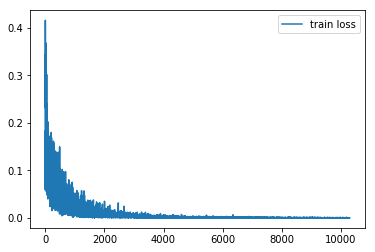

In [167]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()
plot_loss(train_loss)

In [176]:
from sklearn.metrics.pairwise import cosine_similarity
def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        #original_labels=[]
        for batch_idx, (x0, x1, labels) in enumerate(test_loader):
            labels = labels.float()
            x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
            output1, output2 = model(x0, x1)
            similarity=cosine_similarity(output1.detach().numpy(), output2.detach().numpy())
            print ("label: {}".format(labels))
            print ("similarity: {}".format(similarity))
            
def testing_plots(name_file,model):
        filehandler = open(name_file,"wb")
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        pickle.dump(dict_pickle,filehandler)
        plot_mnist(numpy_all, numpy_labels)
        filehandler.close()

In [177]:
test_model(model)

label: tensor([0., 1., 0., 0., 0., 0., 1., 0.])
similarity: [[ 0.3298342  -0.98003775 -0.5197776   0.9806874  -0.17391077  1.
  -0.9457348   0.9806875 ]
 [-0.92817706  0.15434137 -0.8769077   0.23967853  0.975901    0.0451692
   0.2818901   0.23967865]
 [-0.9991715   0.4755301  -0.6659634  -0.09841147  0.9927341  -0.29114276
   0.58620715 -0.09841141]
 [-0.19260639  0.94193286  0.6356891  -0.9985129   0.03248349 -0.98989093
   0.89008784 -0.998513  ]
 [ 0.13882792 -0.9222268  -0.6768248   0.9999998   0.0220488   0.9806874
  -0.86391795  0.99999994]
 [-0.9870149   0.3662213  -0.75088847  0.0220488   1.0000002  -0.17391077
   0.48446172  0.02204892]
 [-0.7769365   0.9381627  -0.00706653 -0.7313429   0.66571885 -0.8506073
   0.97530264 -0.7313429 ]
 [-0.7769365   0.9381627  -0.00706653 -0.7313429   0.66571885 -0.8506073
   0.97530264 -0.7313429 ]]
label: tensor([1., 1., 0., 1., 1., 1., 0., 0.])
similarity: [[ 0.98977745 -0.9748548  -0.9991715  -0.16617358 -0.7793565   0.38362318
  -0.9281